# 13 kNN Exploration

We are now ready to plot the average distances between neighboring oil glands.

The average distance between each oil gland and its 100 nearest neighbors has been compiled in `merged/avg_knn_distances.csv` for all 161 citrus fruits.

- Plot the average distance between each oil gland and its nearest neighbor, its 2nd nearest neighbor, 3rd nearest neighbor,..., and so on until its 25th neighbor.
- We pick only 25 neighbors to keep distances very local, so they won't be affected by the curvature of the ellipsoid.
- Thus it is safe to use the Euclidean distance

<img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/knn01_panel.svg" width=700>

In [1]:
import glob
import os
import textwrap
import string

from sklearn import neighbors as nn
from sklearn import decomposition as decomp
from sklearn import preprocessing as prep
from sklearn.metrics import r2_score

import numpy as np
import numpy.polynomial.polynomial as P

import pandas as pd

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from regress2 import regress2

### Load the compiled data measurements

In [2]:
df = pd.read_csv('../data/allometry/volumes_and_sphericities.csv')
print(df.shape)
df.head()

(161, 24)


,citrus_id,label,kind,whole,exocarp,endocarp,rind,spine,mesocarp,oil_glands,...,sneed,janke,equancy,rho,area,volume,density_whole,density_exocarp,density_area,density_volume
0,C01_CRC2317_18B-18-9,L00,Lemons and Lemon Hybrids,160.687610,34.104516,88.077546,47.450018,6.902806,40.547212,0.228940,...,0.951930,0.950575,0.912011,0.991301,131.552197,141.634935,51.136488,240.935831,62.461899,58.015348
1,C01_CRC2317_18B-18-9,L01,Lemons and Lemon Hybrids,86.992947,16.597155,50.561608,26.259460,3.501201,22.758259,0.180907,...,0.983618,0.983413,0.965487,0.998762,85.078009,73.772020,66.304226,347.529450,67.796603,78.186825
2,C01_CRC2317_18B-18-9,L02,Lemons and Lemon Hybrids,82.898044,16.715139,51.140166,20.911448,1.698778,19.212670,0.172182,...,0.951965,0.950623,0.912486,0.991368,86.859773,75.990242,72.438380,359.255168,69.134419,79.023304
3,C01_CRC2317_18B-18-9,L03,Lemons and Lemon Hybrids,62.717743,14.892982,37.671975,14.998806,1.627702,13.371095,0.175542,...,0.962920,0.962225,0.940127,0.995483,70.871279,56.052537,92.748873,390.586653,82.078383,103.777639
4,C02_CRC3919_18A-24-1,L00,Lemons and Lemon Hybrids,103.970975,23.082609,61.024476,26.689248,1.951175,24.738073,0.573769,...,0.952981,0.949677,0.878024,0.981572,100.580813,94.474523,126.814238,571.209261,131.088620,139.561435


### Get the citrus groups of interest

In [3]:
citrus_names = ['Lemons and Lemon Hybrids', 'Mandarins and Mandarin Hybrids', 'Pummelos and Pummelo Hybrids', 
                'Sour Oranges and their hybrids', 'Sweet Oranges', 'Papedas', 'Trifoliates and Trifoliate Hybrids',
                'Microcitrus', 'Kumquats']
citrus_names = sorted(citrus_names)
citrus_names.append('Other')
citrus_ss = [[] for i in range(len(citrus_names))]
citrus_dict = dict(zip(citrus_names, citrus_ss))

for i in range(len(df)):
    kind = df.iloc[i,2]
    citrus_dict[kind].append(i)
keys = list(citrus_dict.keys())

### Load the kNN average distances for each citrus

In [4]:
dst = '../data/allometry/'
knn = pd.read_csv(dst + 'avg_knn_distances.csv').iloc[:,3:].values

### Observe the kNN distance distribution for a particular citrus group.

- With `keys[8]` we refer to Trifoliates
- We observe that the distance to neighbor grows following a square root model.
- We thus fit a linear model between the squared distance and the neighbor index.

In [5]:
knn_max = 25
i = 8
key = keys[i]
xx = np.arange(knn_max)+1
yy = np.mean(knn[citrus_dict[key],:knn_max], axis = 0)**2

new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
foo = new_series.convert().coef
r2 = r2_score(yy, new_series(xx))
print(key, foo, '\t', r2)

Trifoliates and Trifoliate Hybrids [0.05925324 0.5464681 ] 	 0.9999876901962277


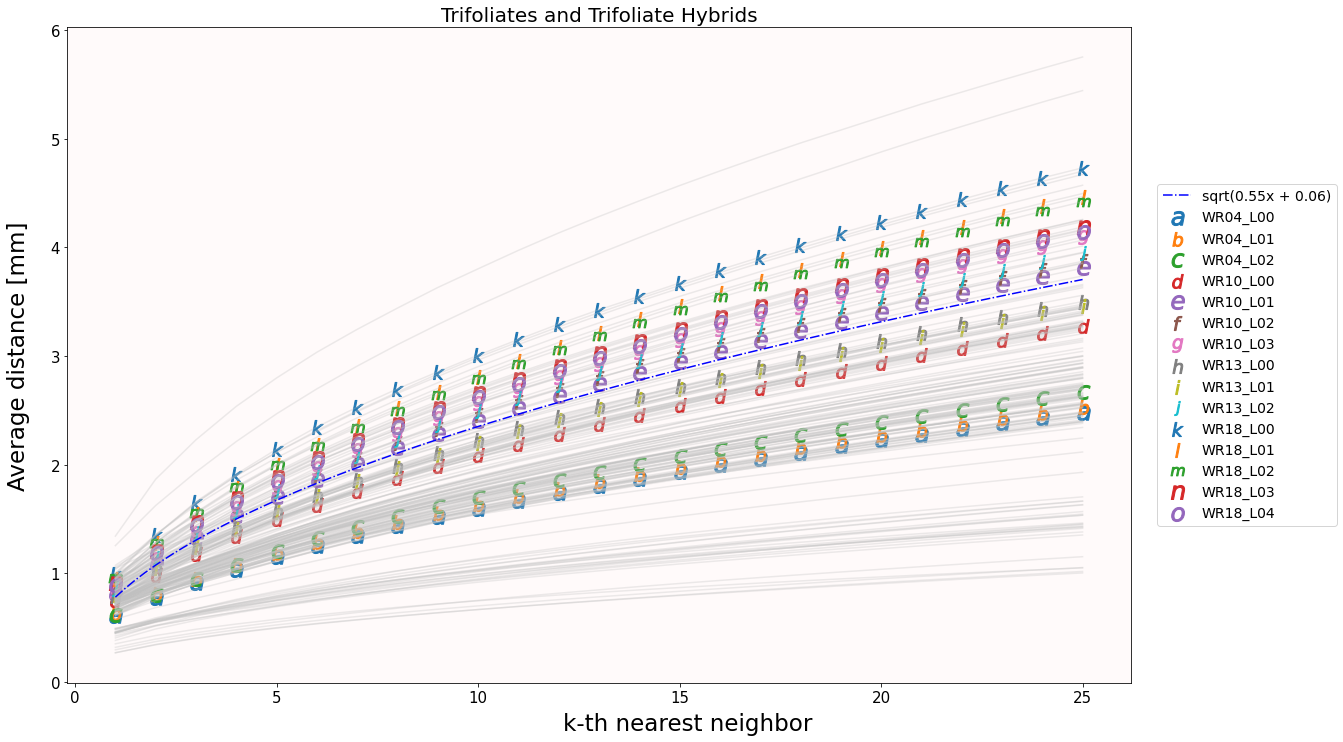

In [6]:
fs = 20
fig, ax = plt.subplots(1,1,figsize=(18,10), sharex=True, sharey=True)

ax.set_facecolor('snow')
ax.tick_params(labelsize=15)
for j in range(len(knn)):
    ax.plot(xx, knn[j, :knn_max],
               color='silver', alpha=0.3)
for i,j in enumerate(citrus_dict[key]):
    mark = '$' + string.ascii_letters[i] + '$'
    bcode = int(df.citrus_id[j].split('_')[0][-2:])
    if bcode not in [9]:
        ax.scatter(xx, knn[j, :knn_max],
                   s=200, marker=mark,
                   label=df.iloc[j,0].split('_')[0] + '_' + df.iloc[j,1])
#bar = ax.axline(xy1=(0,foo[0]), slope=foo[1], color='b', label='r', ls='-.')
labm = 'sqrt({:.2f}x + {:.2f})'.format(foo[1],foo[0])
ax.plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
        color='b', label=labm, ls='-.')
ax.set_title(key, fontsize=fs)
#ax.set_xlabel(, fontsize=fs);
#ax.set_ylabel(, fontsize=fs);
ax.legend(loc='right', bbox_to_anchor=(1.2,0.5), fontsize=14)
fig.text(0.5, -0.02, 'k-th nearest neighbor', ha='center', fontsize=23)
fig.text(-0.025, 0.5, 'Average distance [mm]', va='center', rotation='vertical', fontsize=23)

#fig.suptitle('Avg distance to {:02d}-nearest neighbors'.format(knn_max), fontsize=28);
fig.tight_layout();

## Plot the kNN distribution for all the groups

- For each group, we fit a square root model

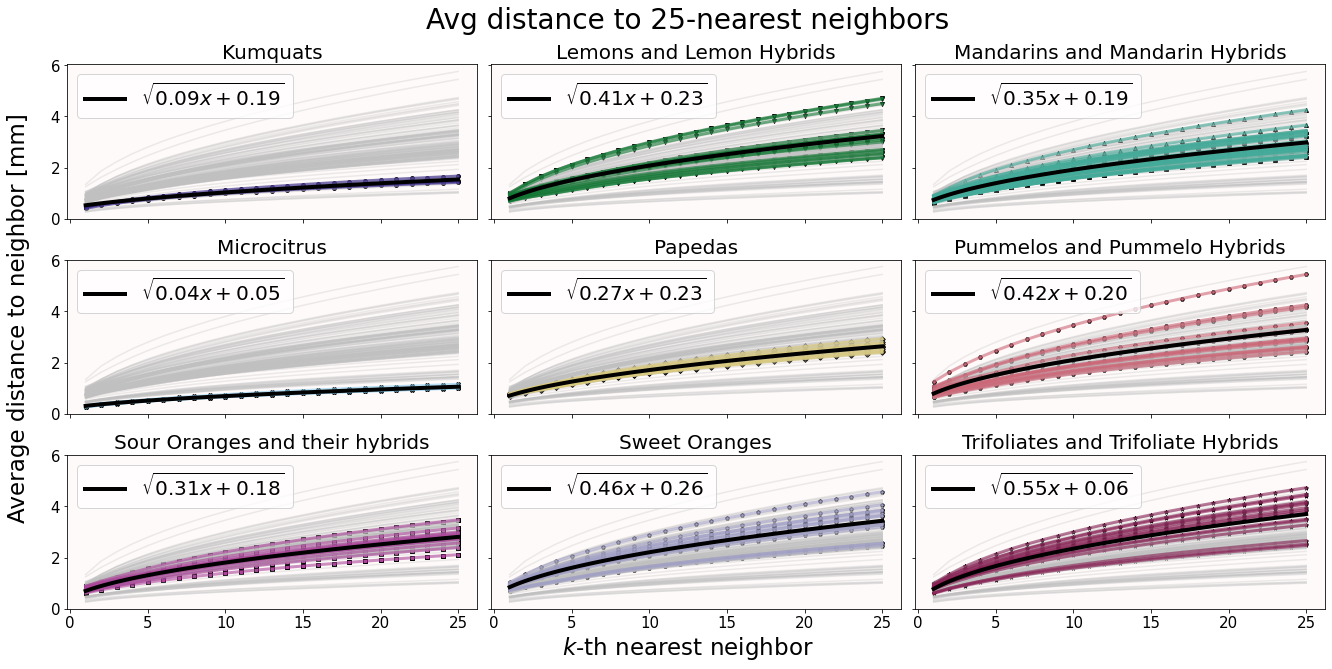

In [7]:
marker = ['o', 'v', '^', 'X', 'D', 
          'H', 's', 'p', '*', 'P']
col_tol = ['#332288', '#117733', '#44aa99', '#88ccee', '#ddcc77', 
           '#cc6677', '#aa4499', '#a09fc5', '#882255', '#111111']
fs = 20

knn_max = 25
knn2 = knn
fig, ax = plt.subplots(3,3,figsize=(18,9), sharex=True, sharey=True)
ax = ax.ravel()
xx = np.arange(knn_max)+1

for i in range(len(ax)):
    key = keys[i]
    yy = np.mean(knn[citrus_dict[key],:knn_max], axis = 0)**2
    new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
    foo = new_series.convert().coef
    
    labm = '$\\sqrt{{{:.2f}x + {:.2f}}}$'.format(foo[1],foo[0])
    
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=15)
    for j in range(len(knn)):
        if j not in citrus_dict[key]:
            ax[i].plot(xx, knn2[j, :knn_max],color='silver', alpha=0.3)
            
    for j in citrus_dict[key]:
        ax[i].plot(xx, knn2[j, :knn_max],
                   color=col_tol[i], lw=3, alpha=0.6)
    for j in citrus_dict[key]:
        ax[i].scatter(xx, knn2[j, :knn_max], 
                      s=15, alpha=1,
                      marker=marker[i], color=col_tol[i], 
                      edgecolor='k', linewidth=1);
    ax[i].set_title(key, fontsize=fs)
    ax[i].plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
                color='k', label=labm, ls='-', lw=4)
    ax[i].legend(fontsize=20)
#ax.set_xlabel(, fontsize=fs);
#ax.set_ylabel(, fontsize=fs);
fig.text(0.5, -0.02, '$k$-th nearest neighbor', ha='center', fontsize=23)
fig.text(-0.025, 0.5, 'Average distance to neighbor [mm]', va='center', rotation='vertical', fontsize=23)

fig.suptitle('Avg distance to {:02d}-nearest neighbors'.format(knn_max), fontsize=28);
fig.tight_layout();

pname = dst + 'panel_knn{:02d}_growth'.format(knn_max)
#plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')

fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

### Perform PCA of the average distance to the 25 nearest neighbors

In [8]:
knn_max = 25
vals = knn[:, :knn_max].copy()
scaler = prep.StandardScaler(with_mean=True, with_std=True)
scaler.fit(vals)
vals = scaler.transform(vals)

pca_params = {'n_components': None, 'whiten': False}
pca = decomp.PCA(**pca_params)
pca.fit(vals)
vals = pca.transform(vals)

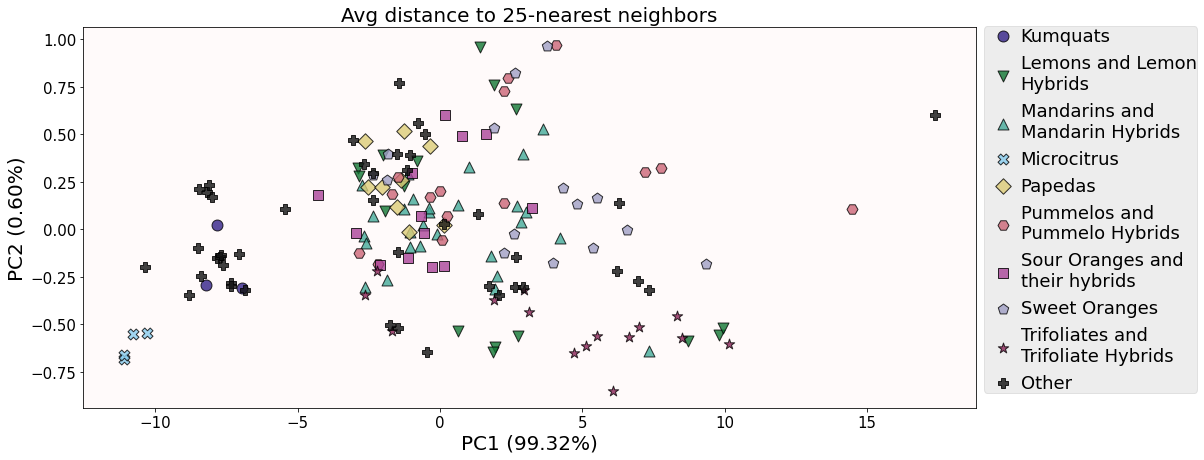

In [9]:
fig, ax = plt.subplots(1,1,figsize=(16,7))

for i,key in enumerate(citrus_dict):
    ax.scatter(vals[citrus_dict[key], 0], vals[citrus_dict[key], 1], s=120, alpha=0.8,
               marker=marker[i], color=col_tol[i], label=key,
               edgecolor='k', linewidth=1);
ax.set_xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0]*100), fontsize=fs);
ax.set_ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1]*100), fontsize=fs);

ax.set_facecolor('snow')
ax.tick_params(labelsize=15)
h, l = ax.get_legend_handles_labels()
l = ([textwrap.fill(t, 18)  for t in l])

fig.legend(h,l,fontsize=18, ncol=1,framealpha=0.4, facecolor='lightgray', loc='upper right',
           bbox_to_anchor=(1.1, 0.9), borderpad=0.05,
           edgecolor='silver', handletextpad=0.);
ax.set_title('Avg distance to {:02d}-nearest neighbors'.format(knn_max), fontsize=fs);

pname = dst + 'pca_knn{:02d}'.format(knn_max)
#plt.savefig(pname+'.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')
fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

## Allometry regarding the average distance to nearest neighbor

- We observe that this distance is highly correlated with fruit size and oil gland density

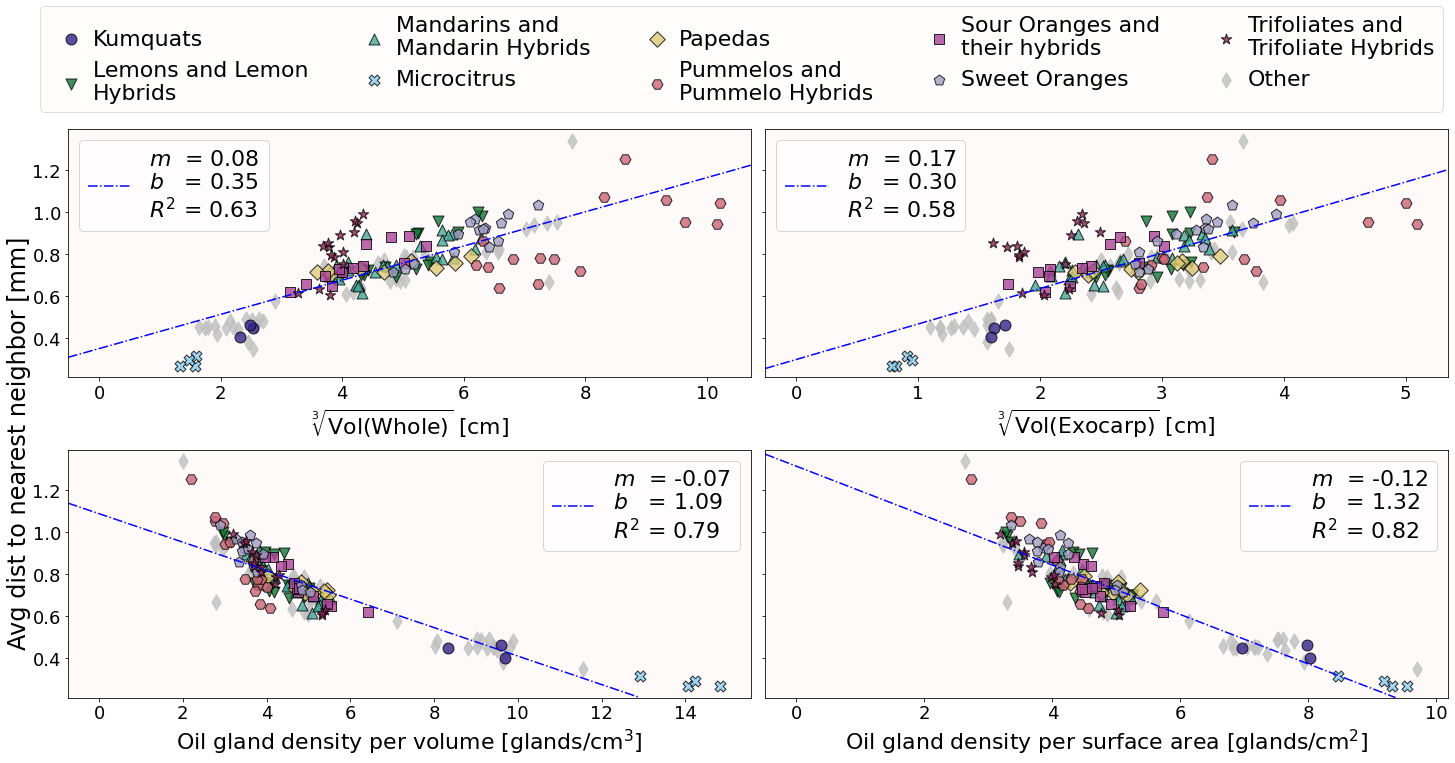

In [7]:
fs = 22
marker = ['o', 'v', '^', 'X', 'D', 
          'H', 's', 'p', '*', 'P']
col_tol = ['#332288', '#117733', '#44aa99', '#88ccee', '#ddcc77', 
           '#cc6677', '#aa4499', '#a09fc5', '#882255', '#111111']

keys = list(citrus_dict.keys())
fig, ax = plt.subplots(2,2,figsize=(20,9), sharey=True)
ax = ax.ravel()
trait = ['whole', 'exocarp', 'oil_glands', 'density_area']
trait = ['density_whole', 'density_exo', 'density_vol', 'density_area']
trait = ['whole', 'exocarp', 'density_whole', 'density_exo', 'density_vol', 'density_area']
trait = ['whole', 'exocarp', 'density_whole', 'density_area']

for i in range(len(ax)):
    xx = np.cbrt(df[trait[i]])
    yy = knn[:,0]
    new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
    foo = new_series.convert().coef
    r2 = r2_score(yy, new_series(xx))
    label = '$m$  = {:.2f}\n$b$   = {:.2f}\n$R^2$ = {:.2f}'.format(foo[1], foo[0], r2)
    ax[i].axline(xy1=(0,foo[0]), slope=foo[1], color='b', ls='-.', label=label)
    if i == 2:
        ax[i].legend(loc = 'upper right', fontsize=fs)
        ax[i].set_xlabel('Oil gland density per volume [glands/cm$^3$]', fontsize=fs)
    elif i == 3:
        ax[i].legend(loc = 'upper right', fontsize=fs)
        ax[i].set_xlabel('Oil gland density per surface area [glands/cm$^2$]', fontsize=fs)
    else:
        ax[i].legend(loc = 'upper left', fontsize=fs)
        tt = '\;'.join(trait[i].title().split('_'))
        ax[i].set_xlabel('$\sqrt[3]{{\\rm Vol({})}}$ [cm]'.format(tt), fontsize=fs);

    key = keys[-1]
    ax[i].scatter(xx[citrus_dict[key]], yy[citrus_dict[key]], s=120, alpha=0.8,
               marker='d', color='silver', label='Other');
    for j in range(len(keys)-1):
        key = keys[j]
        ax[i].scatter(xx[citrus_dict[key]], yy[citrus_dict[key]], s=120, alpha=0.8,
                   marker=marker[j], color=col_tol[j], label=key,
                   edgecolor='k', linewidth=1);
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=18)
    h, l = ax[i].get_legend_handles_labels()

ordering = list(range(2,len(keys)+1)) + [1]
hh = [h[k] for k in ordering]
ll = [textwrap.fill(l[k],18) for k in ordering]

fig.legend(hh,ll,fontsize=22, ncol=5,framealpha=0.5, facecolor='snow', loc='upper center',
           bbox_to_anchor=(0.5, 1.19),
           edgecolor='silver', handletextpad=0.);

fig.text(-0.01, 0.5, 'Avg dist to nearest neighbor [mm]', va='center', rotation='vertical', fontsize=fs+2)
#ax[0].set_ylabel('Avg dist to nearest neighbor [mm]', fontsize=fs);

fig.tight_layout();

pname = dst + 'knn01_panel'
#plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')
fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

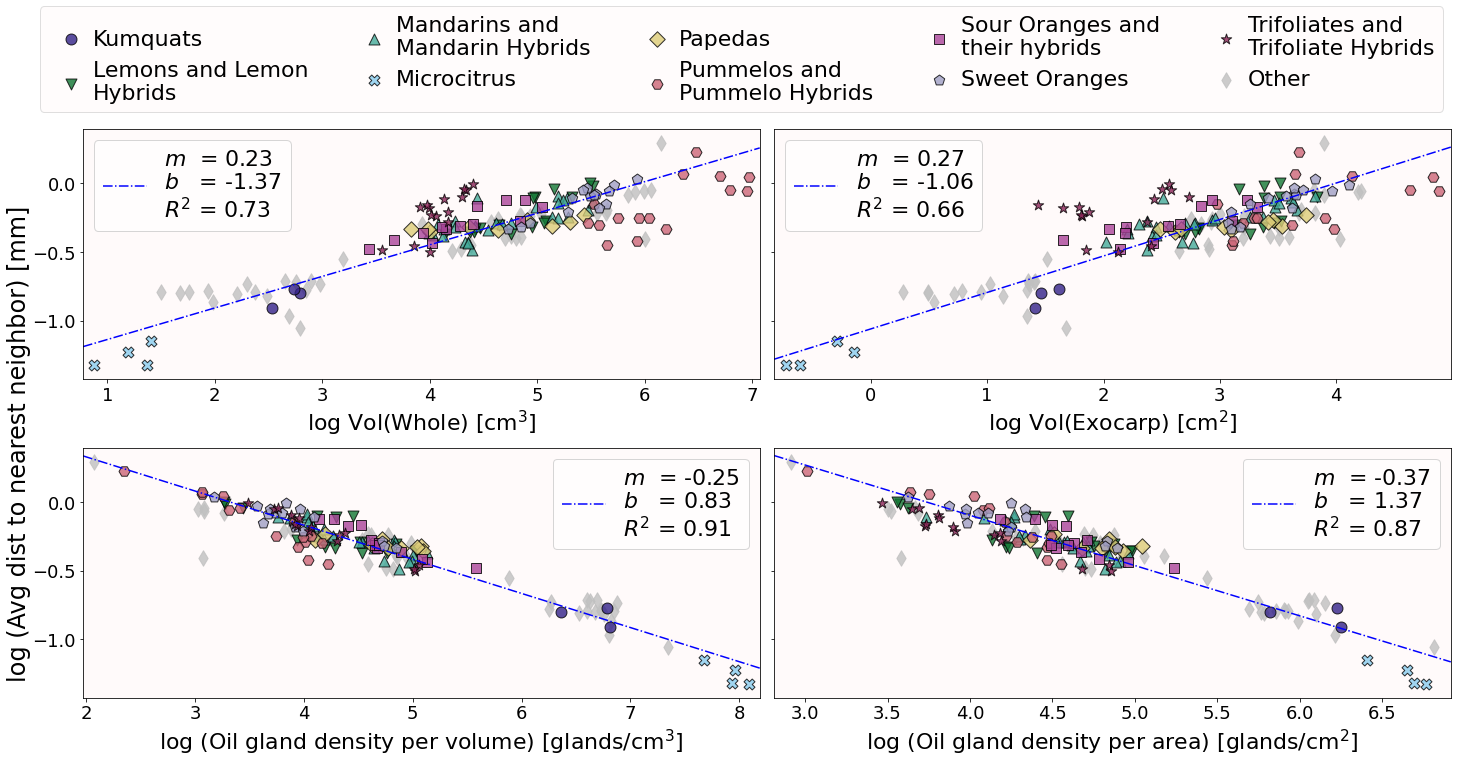

In [5]:
fs = 22
marker = ['o', 'v', '^', 'X', 'D', 
          'H', 's', 'p', '*', 'P']
col_tol = ['#332288', '#117733', '#44aa99', '#88ccee', '#ddcc77', 
           '#cc6677', '#aa4499', '#a09fc5', '#882255', '#111111']

keys = list(citrus_dict.keys())
fig, ax = plt.subplots(2,2,figsize=(20,9), sharey=True)
ax = ax.ravel()
trait = ['whole', 'exocarp', 'oil_glands', 'density_area']
trait = ['density_whole', 'density_exo', 'density_vol', 'density_area']
trait = ['whole', 'exocarp', 'density_whole', 'density_exo', 'density_vol', 'density_area']
trait = ['whole', 'exocarp', 'density_whole', 'density_area']

collabs = ['log Vol(Whole) [cm$^3$]', 'log Vol(Exocarp) [cm$^2$]',
           'log (Oil gland density per volume) [glands/cm$^3$]',
           'log (Oil gland density per area) [glands/cm$^2$]']

for i in range(len(ax)):
    xx = np.log(df[trait[i]])
    yy = np.log(knn[:,0])
    rma = regress2(xx, yy, _method_type_2="reduced major axis")
    r2 = r2_score(yy, rma['predict'])
    
    ax[i].set_xlim((np.min(xx)-0.1, np.max(xx)+0.1))
    ax[i].set_ylim((np.min(yy)-0.1, np.max(yy)+0.1))
    
    label = '$m$  = {:.2f}\n$b$   = {:.2f}\n$R^2$ = {:.2f}'.format(rma['slope'], rma['intercept'], r2)
    ax[i].axline(xy1=(0,rma['intercept']), slope=rma['slope'], color='b', ls='-.', label=label)
    
    if i in [2,3]:
        ax[i].legend(loc = 'upper right', fontsize=fs)
        
    else:
        ax[i].legend(loc = 'upper left', fontsize=fs)
    
    ax[i].set_xlabel(collabs[i], fontsize=fs);

    key = keys[-1]
    ax[i].scatter(xx[citrus_dict[key]], yy[citrus_dict[key]], s=120, alpha=0.8,
               marker='d', color='silver', label='Other');
    for j in range(len(keys)-1):
        key = keys[j]
        ax[i].scatter(xx[citrus_dict[key]], yy[citrus_dict[key]], s=120, alpha=0.8,
                   marker=marker[j], color=col_tol[j], label=key,
                   edgecolor='k', linewidth=1);
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=18)
    h, l = ax[i].get_legend_handles_labels()

ordering = list(range(2,len(keys)+1)) + [1]
hh = [h[k] for k in ordering]
ll = [textwrap.fill(l[k],18) for k in ordering]

fig.legend(hh,ll,fontsize=22, ncol=5,framealpha=0.5, facecolor='snow', loc='upper center',
           bbox_to_anchor=(0.5, 1.19),
           edgecolor='silver', handletextpad=0.);

fig.text(-0.01, 0.5, 'log (Avg dist to nearest neighbor) [mm]', va='center', rotation='vertical', fontsize=fs+2)
#ax[0].set_ylabel('Avg dist to nearest neighbor [mm]', fontsize=fs);

fig.tight_layout();

pname = dst + 'knn01_panel_log'
#plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')
fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

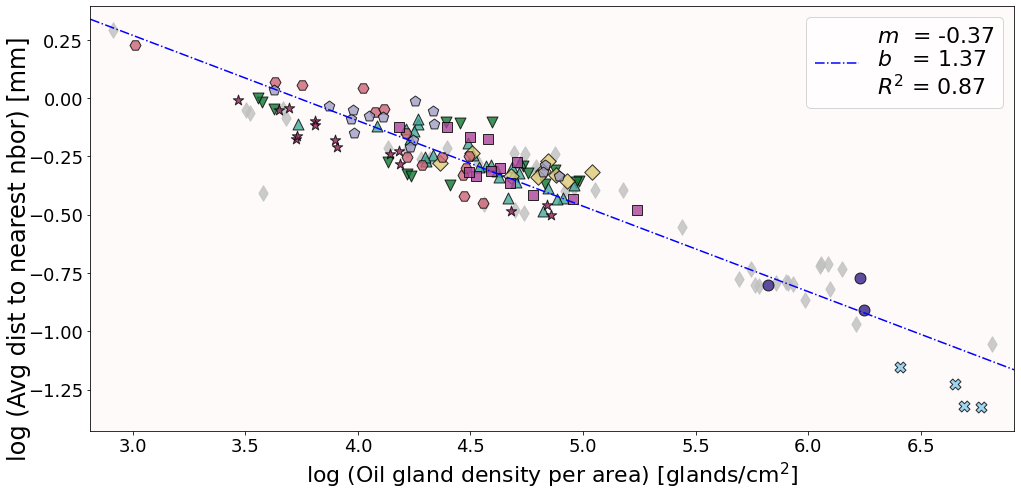

In [14]:
fs = 22
marker = ['o', 'v', '^', 'X', 'D', 
          'H', 's', 'p', '*', 'P']
col_tol = ['#332288', '#117733', '#44aa99', '#88ccee', '#ddcc77', 
           '#cc6677', '#aa4499', '#a09fc5', '#882255', '#111111']

keys = list(citrus_dict.keys())
fig, ax = plt.subplots(1,1,figsize=(14,7), sharey=True)
ax = np.atleast_1d(ax).ravel()
trait = ['density_area']

collabs = ['log (Oil gland density per area) [glands/cm$^2$]']

for i in range(len(ax)):
    xx = np.log(df[trait[i]])
    yy = np.log(knn[:,0])
    rma = regress2(xx, yy, _method_type_2="reduced major axis")
    r2 = r2_score(yy, rma['predict'])
    
    ax[i].set_xlim((np.min(xx)-0.1, np.max(xx)+0.1))
    ax[i].set_ylim((np.min(yy)-0.1, np.max(yy)+0.1))
    
    label = '$m$  = {:.2f}\n$b$   = {:.2f}\n$R^2$ = {:.2f}'.format(rma['slope'], rma['intercept'], r2)
    ax[i].axline(xy1=(0,rma['intercept']), slope=rma['slope'], color='b', ls='-.', label=label)
    
    if i in [0,1]:
        ax[i].legend(loc = 'upper right', fontsize=fs)
        
    else:
        ax[i].legend(loc = 'upper left', fontsize=fs)
    
    ax[i].set_xlabel(collabs[i], fontsize=fs);

    key = keys[-1]
    ax[i].scatter(xx[citrus_dict[key]], yy[citrus_dict[key]], s=120, alpha=0.8,
               marker='d', color='silver', label='Other');
    for j in range(len(keys)-1):
        key = keys[j]
        ax[i].scatter(xx[citrus_dict[key]], yy[citrus_dict[key]], s=120, alpha=0.8,
                   marker=marker[j], color=col_tol[j], label=key,
                   edgecolor='k', linewidth=1);
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=18)
    h, l = ax[i].get_legend_handles_labels()

ordering = list(range(2,len(keys)+1)) + [1]
hh = [h[k] for k in ordering]
ll = [textwrap.fill(l[k],18) for k in ordering]

#fig.legend(hh,ll,fontsize=22, ncol=5,framealpha=0.5, facecolor='snow', loc='upper center',
#           bbox_to_anchor=(0.5, 1.19),
#           edgecolor='silver', handletextpad=0.);

fig.text(-0.01, 0.5, 'log (Avg dist to nearest nbor) [mm]', va='center', rotation='vertical', fontsize=fs+2)
#ax[0].set_ylabel('Avg dist to nearest neighbor [mm]', fontsize=fs);

fig.tight_layout();

pname = dst + 'knn01_panel_log_density'
#plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')
fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

### PCs are highly correlated, which explains why PC1 explains 99% of variance!

- Not surprising given that a root model fits nicely wrt knn index

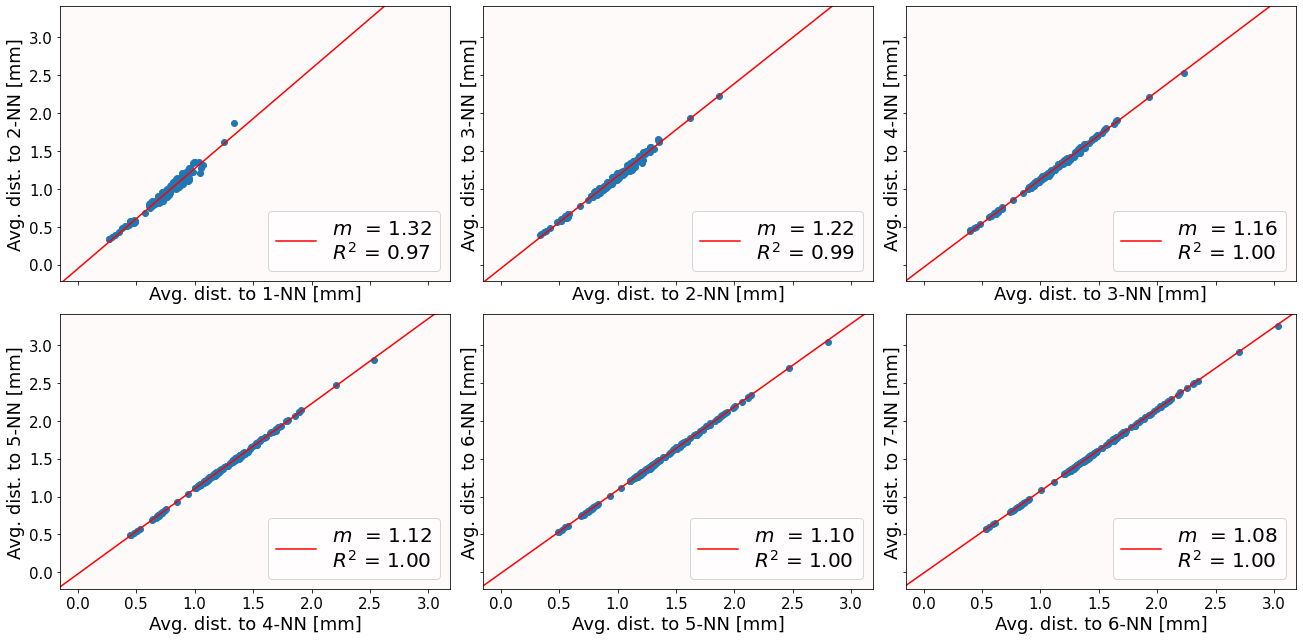

In [11]:
fig, ax = plt.subplots(2,3,figsize=(18,9), sharex=True, sharey=True)
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=15)
    ax[i].scatter(knn[:,i], knn[:,i+1])
    ax[i].set_xlabel('Avg. dist. to {}-NN [mm]'.format(i+1), fontsize=18)
    ax[i].set_ylabel('Avg. dist. to {}-NN [mm]'.format(i+2), fontsize=18)
    new_series = P.Polynomial.fit(knn[:,i],knn[:,i+1], deg=1, full=False)
    r2 = r2_score(knn[:,i+1], new_series(knn[:,i]))
    foo = new_series.convert().coef
    ax[i].axline(xy1=(0,foo[0]), slope=foo[1], color='r', 
                 label='$m$  = {:.2f}\n$R^2$ = {:.2f}'.format(foo[1], r2))
    ax[i].legend(loc='lower right', fontsize=20)
    
fig.tight_layout();
pname = dst + 'knn_clust/knn_linear_relationship'

## Compare kNN average distances whe the points follow different distributions on the unit sphere

### Uniform distribution

- Taken from the the previous notebook

In [13]:
src = '../data/allometry/'
filename = src + 'uniform_distribution_knn.csv'
unif = np.loadtxt(filename, delimiter=',')

### von Mises-Fisher distribution

In [15]:
filename = src + 'bingham_distribution_2,1_knn.csv'
filename = src + 'vmf_distribution_1_knn.csv'
vmf = np.loadtxt(filename, delimiter=',')

### Equispaced distribution

- Each point is roughly the same distance apart from each other.
- Mathematically speaking, distributing $N$ equidistant points on a sphere is a problem that can be posed in a number of ways, all part of the general $s$-energy Riesz Problem.
- The exact solution is unknown for the vast majority of $N$ values
- See [(Kuijlaars _et al._ 2007)](https://doi.org/10.1016/j.cam.2005.04.074) and [(Saff and Kuijlaars, 1997)](https://doi.org/10.1007/BF03024331) for more details
- We use an approximation by [Deserno (2004)](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf)

In [16]:
# Algorithm adapted from 
#
# Deserno, Markus (2004) "How to generate equidistributed points on the surface of a sphere"
# https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf
#
def regular_directions(N=50, r=1, dims=3):
    if dims==2:
        eq_angles = np.linspace(0, 2*np.pi, num=N, endpoint=False)
        return np.column_stack((np.cos(eq_angles), np.sin(eq_angles)))

    if dims==3:
        dirs = np.zeros((N, 3), dtype=np.float64)
        i = 0
        a = 4*np.pi*r**2/N
        d = np.sqrt(a)
        Mtheta = np.round(np.pi/d)
        dtheta = np.pi/Mtheta
        dphi = a/dtheta
        for m in range(int(Mtheta)):
            theta = np.pi*(m + 0.5)/Mtheta
            Mphi = np.round(2*np.pi*np.sin(theta)/dphi)
            for n in range(int(Mphi)):
                phi = 2*np.pi*n/Mphi
                # sometimes we get an error due to i == N for some choices of N
                if i < N:
                    dirs[i,:] = r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)
                    i += 1

        return dirs
    else:
        print("Function implemented only for 2 and 3 dimensions")

### Compute average distance to nearest neighbors

In [18]:
neigh = nn.NearestNeighbors(n_neighbors = 100, radius = 1, algorithm='kd_tree', metric='euclidean')
NDist = np.zeros((len(df), 100))
print(NDist.shape)

(161, 100)


In [19]:
for i in range(len(NDist)):
    N = df['num_glands'][i]
    foo = regular_directions(N)
    neigh.fit(foo)
    ndist, nind = neigh.kneighbors(return_distance=True)
    ndist = ndist.squeeze()
    
    NDist[i] = np.mean(ndist, axis=0)

### Save the results of the equispaced distribution

In [20]:
filename = src + 'regular_distribution_knn.csv'
np.savetxt(filename, NDist, delimiter=',')

## Plot a comparison

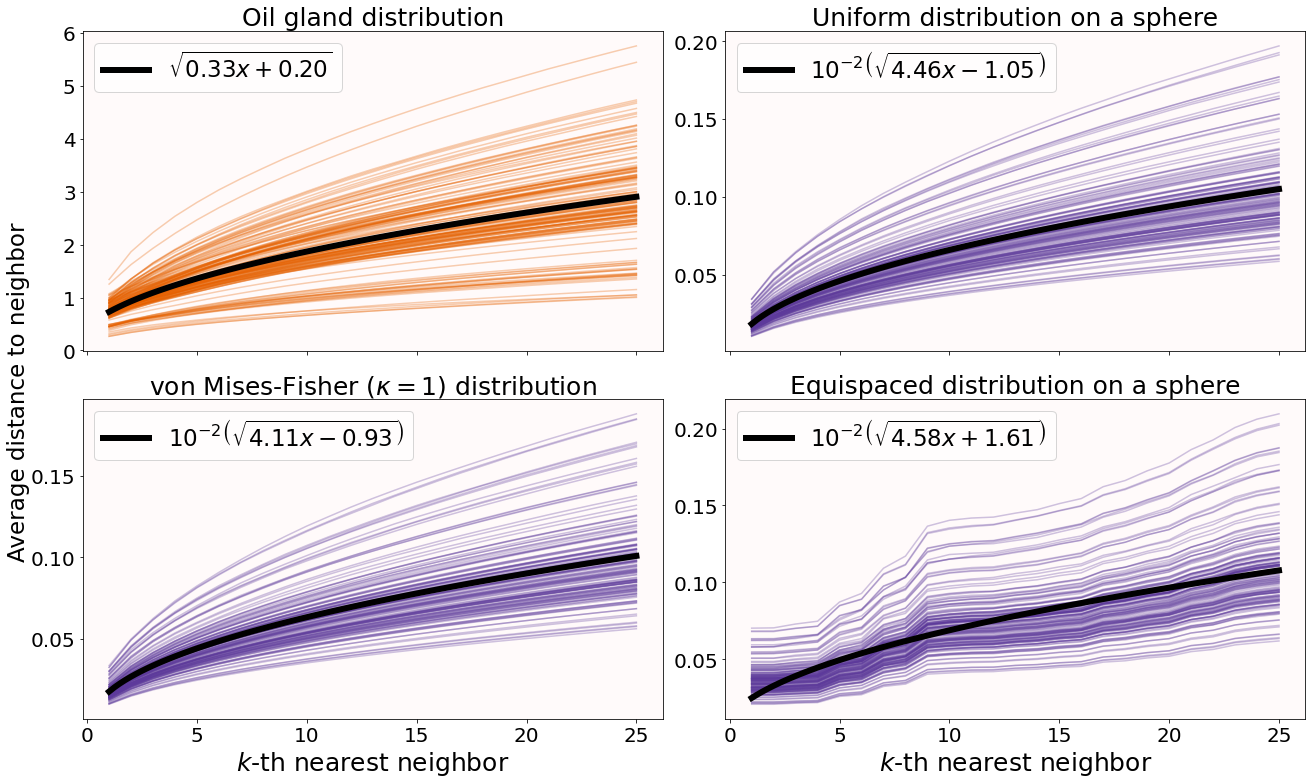

In [24]:
highres = ['#5d3a9b', '#e66100']
fs = 20
tfs = 25
knn_max = 25
fig, ax = plt.subplots(2,2,figsize=(18,11), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()
xx = np.arange(knn_max)+1
for i,data in enumerate([unif, vmf, NDist]):
    i += 1
    yy = np.mean(data[:, :knn_max], axis = 0)**2
    new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
    foo = new_series.convert().coef
    if foo[0] < 0:
        labm = '$10^{{-2}}\\left(\\sqrt{{{:.2f}x {:.2f}}}\\right)$'.format(foo[1]*1e4,foo[0]*1e4)
    else:
        labm = '$10^{{-2}}\\left(\\sqrt{{{:.2f}x + {:.2f}}}\\right)$'.format(foo[1]*1e4,foo[0]*1e4)
    for j in range(len(data)):
        ax[i].plot(xx, data[j, :knn_max],color=highres[0], alpha=0.3)

    ax[i].plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
               color='k', label=labm, ls='-', lw=6)

ax[1].set_title('Uniform distribution on a sphere', fontsize=tfs);
ax[2].set_title('von Mises-Fisher ($\\kappa = 1$) distribution', fontsize=tfs);
ax[3].set_title('Equispaced distribution on a sphere', fontsize=tfs);

i = 0
yy = np.mean(knn[:, :knn_max], axis = 0)**2
new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
foo = new_series.convert().coef
labm = '$\\sqrt{{{:.2f}x + {:.2f}}}$'.format(foo[1],foo[0])
for j in range(len(data)):
    ax[i].plot(xx, knn[j, :knn_max],color=highres[1], alpha=0.3)
            
ax[i].plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
           color='k', label=labm, ls='-', lw=6)

ax[i].set_title('Oil gland distribution', fontsize=tfs);

for i in [2,3]:
    ax[i].set_xlabel('$k$-th nearest neighbor', fontsize=tfs)
    
for i in range(len(ax)):
    ax[i].set_facecolor('snow')
    ax[i].legend(fontsize=23)
    ax[i].tick_params(labelsize=20)
    
fig.text(-0.01, 0.5, 'Average distance to neighbor', va='center', rotation='vertical', fontsize=23)
fig.tight_layout();

pname = src + 'uniform_distribution_{}knn'.format(knn_max)
#plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')

fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

# References

- **Deserno, M** (2004) "How to generate equidistributed points on the surface of a sphere".  [PDF](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf)

- **Kuijlaars, ABJ**, **Saff, EB**, **Sun, X** (2007) On separation of minimal Riesz energy points on spheres in Euclidean spaces. _Journal of Computational and Applied Mathematics_. **199**(1), 172-180. [DOI: 10.1016/j.cam.2005.04.074](https://doi.org/10.1016/j.cam.2005.04.074)

- **Saff, EB**, **Kuijlaars, ABJ** (1997) Distributing many points on a sphere. _The Mathematical Intelligencer_ **19**(1), 5-11. [DOI: 10.1007/BF03024331](https://doi.org/10.1007/BF03024331)